In [1]:
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree, get_laplacian, from_networkx, from_scipy_sparse_matrix
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def edge_index_to_adjacency(edge_index, edge_weight, num_nodes):
    adjacency_matrix = torch.zeros((num_nodes, num_nodes))
    adjacency_matrix[edge_index[0], edge_index[1]] = edge_weight
    adjacency_matrix[edge_index[1], edge_index[0]] = edge_weight  # For undirected graph
    return adjacency_matrix

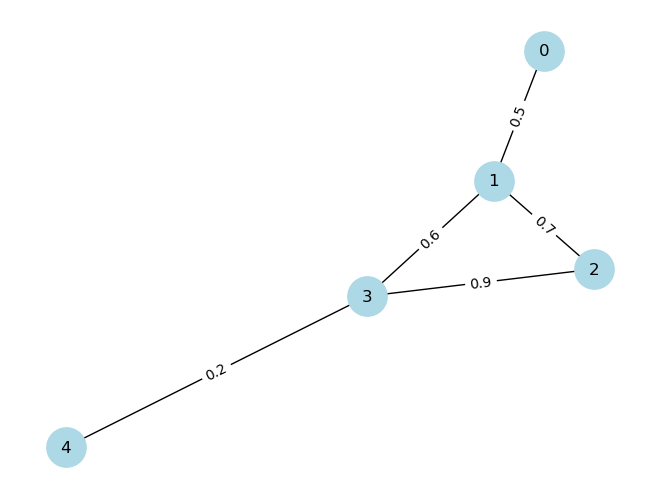

In [3]:
# Create an empty undirected graph
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from([0, 1, 2, 3, 4])

# Add weighted edges to the graph
G.add_weighted_edges_from([(0, 1, 0.5), (1, 2, 0.7), (1, 3, 0.6), (2, 3, 0.9), (3, 4, 0.2)])

# Visualize the graph with labels
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=800, node_color='lightblue')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Show the plot
plt.show()

laplacian_mat = nx.normalized_laplacian_matrix(G).tocsc()

## test laplacian

In [4]:
graphinfo = from_networkx(G)
edge_index, edge_weight = graphinfo.edge_index, graphinfo.weight
laplacian_edge_index, laplacian_edge_weight = get_laplacian(edge_index, edge_weight, normalization='sym')

In [5]:
lapl = edge_index_to_adjacency(laplacian_edge_index, laplacian_edge_weight, graphinfo.num_nodes)

In [6]:
lapl

tensor([[ 1.0000, -0.5270,  0.0000,  0.0000,  0.0000],
        [-0.5270,  1.0000, -0.4125, -0.3430,  0.0000],
        [ 0.0000, -0.4125,  1.0000, -0.5457,  0.0000],
        [ 0.0000, -0.3430, -0.5457,  1.0000, -0.3430],
        [ 0.0000,  0.0000,  0.0000, -0.3430,  1.0000]])

In [7]:
laplacian_mat.toarray()

array([[ 1.        , -0.52704628,  0.        ,  0.        ,  0.        ],
       [-0.52704628,  1.        , -0.41247896, -0.34299717,  0.        ],
       [ 0.        , -0.41247896,  1.        , -0.54570516,  0.        ],
       [ 0.        , -0.34299717, -0.54570516,  1.        , -0.34299717],
       [ 0.        ,  0.        ,  0.        , -0.34299717,  1.        ]])

In [8]:
laplacian_mat.toarray() - lapl.numpy()

array([[-2.22044605e-16, -1.34768038e-08,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-1.34768038e-08, -1.11022302e-16, -2.09222284e-09,
        -6.75085321e-09,  0.00000000e+00],
       [ 0.00000000e+00, -3.18945452e-08,  0.00000000e+00,
        -1.66947557e-08,  0.00000000e+00],
       [ 0.00000000e+00, -6.75085321e-09, -1.66947557e-08,
         0.00000000e+00,  2.30514691e-08],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.30514691e-08,  2.22044605e-16]])

## test matrix-vector multiplication via message passing

In [9]:
class MatVecMult(MessagePassing):
    """
    Chebyshev polynomials as a custom message passing layer.
    need another layer to do the aggregation.
    the normalized laplacian computation is handled as a normalization.
    """
    def __init__(self, edge_index, edge_weight):
        """computes the graph laplacian, ?as well as the basis matrix for the Chebyshev polynomials.

        Args:
            edge_index (tensor): shape (2, E). E is number of edges.
            edge_weight (tensor, optional): shape (E, ).
        """
        super().__init__(aggr="add", node_dim=-3)  # "Add" aggregation.
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        ## using symmetrically normalized laplacian so that the eigenvalues are within [0, 2]
        ## see https://math.stackexchange.com/questions/2511544/largest-eigenvalue-of-a-normalized-graph-laplacian
        self.laplacian_edge_index, self.laplacian_edge_weight = get_laplacian(
            self.edge_index, self.edge_weight, normalization='sym')

    def forward(self, x):
        """_summary_

        Args:
            x (tensor): shape (n, *, *). n is number of nodes.


        Returns:
            tensor: shape (n, *, *).
        """
        return self.propagate(edge_index=self.laplacian_edge_index, x=x, edge_weight=self.laplacian_edge_weight)

    def message(self, x_j):
        # x_j has shape [E, out_channels]
        # Step 4: Normalize node features.
        return self.laplacian_edge_weight.view(-1, 1, 1) * x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        # Step 6: Return new node embeddings.
        return aggr_out

In [10]:
x = torch.rand(5, 1, 1)

In [11]:
lapl @ x.squeeze()

tensor([-0.2426,  0.1426,  0.2026, -0.2063, -0.0158])

In [12]:
multer = MatVecMult(edge_index, edge_weight)
multer(x).squeeze()

tensor([-0.2426,  0.1426,  0.2026, -0.2063, -0.0158])

## Test cheby coefs

In [13]:
def get_cheby_coefs(func, degree, N=1000):
    """
    get the Chebyshev polynomial coefficients of the function.

    Args:
        func (function): the function to be integrated.
        degree (int): the degree of the Chebyshev polynomials. (the min power is 0, the max power is degree - 1)
        a (float): the lower bound of the integration.
        b (float): the upper bound of the integration.
        N (int, optional): the number of points to be used in the integration. Defaults to 1000.

    Returns:
        tensor: shape (k, ). the coefficients of the Chebyshev polynomials.
    
    Note:
        see https://en.wikipedia.org/wiki/Chebyshev_polynomials#Orthogonality for the formula for computing the coefficients.
    """
    ks = torch.arange(N)
    xks = torch.cos(torch.pi * (ks + 0.5) / (N)) + 1 ## reparameterize from [-1, 1] to [0, 2]
    ns = torch.arange(degree).unsqueeze(-1)
    Tn_xks = torch.cos(ns * torch.pi * (ks + 0.5) / (N)) ## shape (degree, N)
    func_xks = func(xks) ## shape (N,)
    coefs = (2 * Tn_xks * func_xks).mean(axis=1) ## shape (degree,)
    coefs[0] /= 2
    # return coefs.squeeze() ## TODO test shape of coefs before squeeze.
    return coefs

In [14]:
def fit_coef(func, alpha, deg, n=1000):
    """
    fit the coefficients of the chebyshev polynomials

    Args:
        func: the function to fit
        alpha: the domain of func is [0, 2*alpha]
        deg: the degree of the polynomial
        n: the number of points to sample

    Returns:
        the coefficients of the chebyshev polynomials
    """    
    thetas = torch.linspace(0, torch.pi, n).reshape(1, -1)
    ks = torch.arange(deg).reshape(-1, 1)
    cs = (torch.cos(ks * thetas) * func(alpha * (torch.cos(thetas) + 1))).mean(axis=1) * 2
    return cs

In [15]:
func = lambda x: np.exp(-3 * x)
coefs1 = get_cheby_coefs(func, degree=10)
coefs2 = fit_coef(func, alpha=1., deg=10)

In [16]:
coefs1

tensor([ 2.4300e-01, -3.9365e-01,  2.2357e-01, -9.5567e-02,  3.2432e-02,
        -9.0819e-03,  2.1591e-03, -4.4543e-04,  8.1080e-05, -1.3185e-05])

In [17]:
coefs2

tensor([ 0.4865, -0.3943,  0.2243, -0.0965,  0.0334, -0.0101,  0.0032, -0.0014,
         0.0011, -0.0010])

## test cheby eval

In [18]:
class ChebyLayer(MessagePassing):
    """
    Chebyshev polynomials as a custom message passing layer.
    need another layer to do the aggregation.
    the normalized laplacian computation is handled as a normalization.
    """
    def __init__(self, edge_index, edge_weight):
        """computes the graph laplacian, ?as well as the basis matrix for the Chebyshev polynomials.

        Args:
            edge_index (tensor): shape (2, E). E is number of edges.
            edge_weight (tensor, optional): shape (E, ).
        """
        super().__init__(aggr="add", node_dim=-3)  # "Add" aggregation.
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        ## using symmetrically normalized laplacian so that the eigenvalues are within [0, 2]
        ## see https://math.stackexchange.com/questions/2511544/largest-eigenvalue-of-a-normalized-graph-laplacian
        self.laplacian_edge_index, self.laplacian_edge_weight = get_laplacian(
            self.edge_index, self.edge_weight, normalization='sym')

    def forward(self, x, coefs, t=None):
        """Evaluate the chebyshev polynomials through recursive message passing.

        Args:
            x (tensor): shape (n, *, *). n is number of nodes.
            coefs (tensor): shape (k). k is the degree of the chebyshev polynomials.
            t (tensor): shape (T, ). T is the number of time points. t is the sample times.

        Returns:
            tensor: shape (n, *, *).
        """
        k = len(coefs)
        assert  k > 2
        T0 = x
        out = coefs[0] * T0
        T1 = self.propagate(edge_index=self.laplacian_edge_index, x=x, edge_weight=self.laplacian_edge_weight)
        out += coefs[1] * T1

        for i in range(2, k):
            T2 = 2 * self.propagate(edge_index=self.laplacian_edge_index, x=T1, edge_weight=self.laplacian_edge_weight) - T0
            out += coefs[i] * T2
            T0, T1 = T1, T2

        return out
        # return self.propagate(edge_index=self.laplacian_edge_index, x=x, edge_weight=self.laplacian_edge_weight)

    def message(self, x_j):
        # x_j has shape [E, out_channels]
        # Step 4: Normalize node features.
        return self.laplacian_edge_weight.view(-1, 1, 1) * x_j

    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]
        # Step 6: Return new node embeddings.
        return aggr_out - x ## reparameterize lambda to range (-1, 1) (L_tilde = L - I, so L_tilde x = L x - x)

In [19]:
cheb = ChebyLayer(edge_index, edge_weight)
y1 = cheb(x, coefs1).squeeze()

In [20]:
lam, V = np.linalg.eigh(laplacian_mat.toarray())
M2 = V @ np.diag(np.exp(- 3 * lam)) @ V.T 
y2 = M2 @ x.squeeze().numpy()

In [21]:
M3 = torch.linalg.matrix_exp(-3 * torch.tensor(laplacian_mat.toarray()).float())
y3 = M3 @ x.squeeze()

In [22]:
y1

tensor([0.3475, 0.6768, 0.6485, 0.6639, 0.2236])

In [23]:
y2

array([0.34751272, 0.67683191, 0.64850767, 0.66386158, 0.22359572])

In [24]:
y3

tensor([0.3475, 0.6768, 0.6485, 0.6639, 0.2236])

In [25]:
y1 - y3

tensor([-6.8545e-07, -8.9407e-07, -9.5367e-07, -1.3113e-06, -5.8115e-07])

## Test Multiple time points

In [26]:
class ChebyLayer(MessagePassing):
    """
    Chebyshev polynomials as a custom message passing layer.
    need another layer to do the aggregation.
    the normalized laplacian computation is handled as a normalization.
    """
    def __init__(self, edge_index, edge_weight):
        """computes the graph laplacian, ?as well as the basis matrix for the Chebyshev polynomials.

        Args:
            edge_index (tensor): shape (2, E). E is number of edges.
            edge_weight (tensor, optional): shape (E, ).
        """
        super().__init__(aggr="add", node_dim=-3)  # "Add" aggregation.
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        ## using symmetrically normalized laplacian so that the eigenvalues are within [0, 2]
        ## see https://math.stackexchange.com/questions/2511544/largest-eigenvalue-of-a-normalized-graph-laplacian
        self.laplacian_edge_index, self.laplacian_edge_weight = get_laplacian(
            self.edge_index, self.edge_weight, normalization='sym')

    def forward(self, x, coefs):
        """Evaluate the chebyshev polynomials through recursive message passing.
        coefs is 2 dimentional with the first dimension to be time points.

        Args:
            x (tensor): shape (n, *, *). n is number of nodes.
            coefs (tensor): shape (T, k). 
                k is the degree of the chebyshev polynomials.
                T is the number of time points. t is the sample times.

        Returns:
            tensor: shape (T, n, *, *).
        """
        k = coefs.size(1)
        assert  k > 2
        T0 = x
        out = coefs[:, 0].view(-1, 1, 1, 1) * T0
        T1 = self.propagate(edge_index=self.laplacian_edge_index, x=x, edge_weight=self.laplacian_edge_weight)
        out += coefs[:, 1].view(-1, 1, 1, 1) * T1

        for i in range(2, k):
            T2 = 2 * self.propagate(edge_index=self.laplacian_edge_index, x=T1, edge_weight=self.laplacian_edge_weight) - T0
            out += coefs[:, i].view(-1, 1, 1, 1) * T2
            T0, T1 = T1, T2

        return out
        # return self.propagate(edge_index=self.laplacian_edge_index, x=x, edge_weight=self.laplacian_edge_weight)

    def message(self, x_j):
        # x_j has shape [E, out_channels]
        # Step 4: Normalize node features.
        return self.laplacian_edge_weight.view(-1, 1, 1) * x_j

    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]
        # Step 6: Return new node embeddings.
        return aggr_out - x ## reparameterize lambda to range (-1, 1) (L_tilde = L - I, so L_tilde x = L x - x)
    
def get_cheby_coefs(func, ts, degree, N=1000):
    """
    get the Chebyshev polynomial coefficients of the function.

    Args:
        func (function): the function to be integrated.
            f(t, lam) has two parameters:
            t is the time point, and lam is the eigenvalue of the laplacian matrix
        ts (tensor): shape (T, ). the sample time points.
        degree (int): the degree of the Chebyshev polynomials. (the min power is 0, the max power is degree - 1)
        N (int, optional): the number of points to be used in the integration. Defaults to 1000.

    Returns:
        tensor: shape (T, k). the coefficients of the Chebyshev polynomials.
    
    Note:
        see https://en.wikipedia.org/wiki/Chebyshev_polynomials#Orthogonality for the formula for computing the coefficients.
    """
    ks = torch.arange(N)
    xks = torch.cos(torch.pi * (ks + 0.5) / (N)) + 1 ## reparameterize from [-1, 1] to [0, 2]
    ns = torch.arange(degree).unsqueeze(-1)
    Tn_xks = torch.cos(ns * torch.pi * (ks + 0.5) / (N)) ## shape (degree, N)
    func_xks = func(ts, xks) ## shape (T, N)
    coefs = (2 * Tn_xks.unsqueeze(0) * func_xks.unsqueeze(1)).mean(axis=-1) ## shape (T, degree)
    coefs[:, 0] /= 2
    return coefs

def heat_eqn_oper(t, lam):
    """
    the function of the heat equation solution.

    Args:
        t (tensor): shape (T, ). the time points.
        lam (tensor): shape (N, ). the sampled points of eigenvalues of the laplacian matrix.

    Returns:
        tensor: shape (T, N). the wave equation solution result for each time t and each sample point of the eigenvalues.
    """
    return torch.exp(- t.view(-1, 1) * lam)

def wave_eqn_oper_x(t, lam):
    """
    the function for computing the wave equation solution's operator on x (initial position) cos(sqrt(lam) * t)

    Args:
        t (tensor): shape (T, ). the time points.
        lam (tensor): shape (N, ). the sampled points of eigenvalues of the laplacian matrix.

    Returns:
        tensor: shape (T, N). the wave equation solution result for each time t and each sample point of the eigenvalues.
    """
    lamsqrt = torch.sqrt(lam)
    tlamsqrt = t.view(-1, 1) * lamsqrt
    oper_x_res = torch.cos(tlamsqrt)
    return oper_x_res

def wave_eqn_oper_y(t, lam):
    """
    the function for computing the wave equation solution's operator on y (initial speed) sin(sqrt(lam) * t) / sqrt(lam)
    Note the t term is not needed for lam_0=0, because 1 equals to the limit of sin(a)/a at 0.

    Args:
        t (tensor): shape (T, ). the time points.
        lam (tensor): shape (N, ). the sampled points of eigenvalues of the laplacian matrix.

    Returns:
        tensor: shape (T, N). the wave equation solution result for each time t and each sample point of the eigenvalues.
    """
    lamsqrt = torch.sqrt(lam)
    tlamsqrt = t.view(-1, 1) * lamsqrt
    oper_y_res = torch.sin(tlamsqrt) / lamsqrt
    return oper_y_res

def get_cheby_coefs_heat(ts, degree, N=1000):
    """
    get the Chebyshev polynomial coefficients of the heat equation.

    Args:
        ts (tensor): shape (T, ). the sample time points.
        degree (int): the degree of the Chebyshev polynomials. (the min power is 0, the max power is degree - 1)
        N (int, optional): the number of points to be used in the integration. Defaults to 1000.

    Returns:
        tensor: shape (T, k). the coefficients of the Chebyshev polynomials.
    """
    return get_cheby_coefs(heat_eqn_oper, ts, degree, N=N)

def get_cheby_coefs_wave(ts, degree, N=1000):
    """
    get the Chebyshev polynomial coefficients of the wave equation.

    Args:
        ts (tensor): shape (T, ). the sample time points.
        degree (int): the degree of the Chebyshev polynomials. (the min power is 0, the max power is degree - 1)
        N (int, optional): the number of points to be used in the integration. Defaults to 1000.

    Returns:
        tuple: the coefficients of the Chebyshev polynomials.
            the first element is the coefficients of the wave equation for x. shape (T, k)
            the second element is the coefficients of the wave equation for y. shape (T, k)
    
    """
    return get_cheby_coefs(wave_eqn_oper_x, ts, degree, N=N), get_cheby_coefs(wave_eqn_oper_y, ts, degree, N=N)


In [27]:
ts = torch.arange(6).float()
coefs_ts = get_cheby_coefs_heat(ts, degree=10)

In [28]:
coefs_ts

tensor([[ 1.0000e+00, -5.5909e-08,  4.8041e-08, -3.4571e-09,  5.9605e-08,
         -8.1897e-08,  9.4175e-09, -1.2255e-07,  4.8637e-08, -7.2718e-09],
        [ 4.6576e-01, -4.1582e-01,  9.9878e-02, -1.6311e-02,  2.0139e-03,
         -1.9982e-04,  1.6554e-05, -1.3008e-06,  1.2726e-07, -8.8811e-09],
        [ 3.0851e-01, -4.3054e-01,  1.8648e-01, -5.7582e-02,  1.3731e-02,
         -2.6596e-03,  4.3313e-04, -6.0928e-05,  7.5526e-06, -8.2606e-07],
        [ 2.4300e-01, -3.9365e-01,  2.2357e-01, -9.5567e-02,  3.2432e-02,
         -9.0819e-03,  2.1591e-03, -4.4543e-04,  8.1077e-05, -1.3182e-05],
        [ 2.0700e-01, -3.5750e-01,  2.3525e-01, -1.2225e-01,  5.1880e-02,
         -1.8489e-02,  5.6582e-03, -1.5141e-03,  3.5940e-04, -7.6569e-05],
        [ 1.8354e-01, -3.2794e-01,  2.3590e-01, -1.3922e-01,  6.8838e-02,
         -2.9081e-02,  1.0677e-02, -3.4565e-03,  9.9884e-04, -2.6030e-04]])

In [29]:
coefs1

tensor([ 2.4300e-01, -3.9365e-01,  2.2357e-01, -9.5567e-02,  3.2432e-02,
        -9.0819e-03,  2.1591e-03, -4.4543e-04,  8.1080e-05, -1.3185e-05])

In [30]:
coefs_ts[3, :]

tensor([ 2.4300e-01, -3.9365e-01,  2.2357e-01, -9.5567e-02,  3.2432e-02,
        -9.0819e-03,  2.1591e-03, -4.4543e-04,  8.1077e-05, -1.3182e-05])

In [31]:
chebs = ChebyLayer(edge_index, edge_weight)
yts = chebs(x, coefs_ts).squeeze()

In [32]:
yts

tensor([[0.1516, 0.7480, 0.8134, 0.5539, 0.1741],
        [0.2894, 0.6834, 0.6970, 0.6500, 0.1991],
        [0.3322, 0.6759, 0.6608, 0.6637, 0.2164],
        [0.3475, 0.6768, 0.6485, 0.6639, 0.2236],
        [0.3536, 0.6782, 0.6440, 0.6627, 0.2260],
        [0.3562, 0.6790, 0.6423, 0.6618, 0.2267]])

In [33]:
x.squeeze()

tensor([0.1516, 0.7480, 0.8134, 0.5539, 0.1741])

In [34]:
y1

tensor([0.3475, 0.6768, 0.6485, 0.6639, 0.2236])

In [35]:
yts[3, :]

tensor([0.3475, 0.6768, 0.6485, 0.6639, 0.2236])

## Test ChebyPolyLayer

In [36]:
class ChebyPolyLayer(MessagePassing):
    """
    Chebyshev polynomials as a custom message passing layer.
    Pass edge_index and edge_weight to the forward method.
    """
    def __init__(self, coefs=None):
        """
        the coefs is fixed for the layer (which is determined by the equation as well as the sampling points)
        can make more flexible by passing time points to forward method. computing the coefficients should'nt be slow.
        Args:
            coefs (tensor): shape (T, k). 
                k is the degree of the chebyshev polynomials.
                T is the number of time points. t is the sample times.
        """
        super().__init__(aggr="add", node_dim=-3)  # "Add" aggregation.
        self.coefs = coefs

    def forward(self, edge_index, edge_weight, x, coefs=None):
        """Evaluate the chebyshev polynomials through recursive message passing.
        coefs is 2 dimentional with the first dimension to be time points.

        Args:
            edge_index (tensor): shape (2, E). E is number of edges.
            edge_weight (tensor, optional): shape (E, ).
            x (tensor): shape (n, *, *). n is number of nodes.
            coefs (tensor): shape (T, k). 
                k is the degree of the chebyshev polynomials.
                T is the number of time points. t is the sample times.

        Returns:
            tensor: shape (T, n, *, *).
        """
        if coefs is None: coefs = self.coefs
        assert coefs is not None
        k = coefs.size(1)
        assert  k > 2
        ## using symmetrically normalized laplacian so that the eigenvalues are within [0, 2]
        ## see https://math.stackexchange.com/questions/2511544/largest-eigenvalue-of-a-normalized-graph-laplacian
        laplacian_edge_index, laplacian_edge_weight = get_laplacian(
            edge_index, edge_weight, normalization='sym')
        T0 = x
        out = coefs[:, 0].view(-1, 1, 1, 1) * T0
        T1 = self.propagate(edge_index=laplacian_edge_index, x=x, edge_weight=laplacian_edge_weight)
        out += coefs[:, 1].view(-1, 1, 1, 1) * T1

        for i in range(2, k):
            T2 = 2 * self.propagate(edge_index=laplacian_edge_index, x=T1, edge_weight=laplacian_edge_weight) - T0
            out += coefs[:, i].view(-1, 1, 1, 1) * T2
            T0, T1 = T1, T2

        return out
        # return self.propagate(edge_index=laplacian_edge_index, x=x, edge_weight=laplacian_edge_weight)

    def message(self, x_j, edge_weight):
        """
        edge_weight is the edge weight of the graph laplacian.
        """
        # x_j has shape [E, out_channels]
        # Step 4: Normalize node features.
        return edge_weight.view(-1, 1, 1) * x_j

    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]
        # Step 6: Return new node embeddings.
        return aggr_out - x ## reparameterize lambda to range (-1, 1) (L_tilde = L - I, so L_tilde x = L x - x)


In [37]:
import torch
cpl = ChebyPolyLayer(coefs_ts)
ycpl1 = cpl(edge_index, edge_weight, x).squeeze()
cpl2 = ChebyPolyLayer()
ycpl2 = cpl2(edge_index, edge_weight, x, coefs_ts).squeeze()

In [38]:
print(torch.allclose(ycpl1, ycpl2))
print(torch.allclose(ycpl1, yts))

True
True


## Test x with shape (n, m)

In [39]:
x = x.squeeze(-1)

In [40]:
x.size()

torch.Size([5, 1])

In [41]:
class ChebyPolyLayer(MessagePassing):
    """
    Chebyshev polynomials as a custom message passing layer.
    Pass edge_index and edge_weight to the forward method.
    """
    def __init__(self, coefs=None):
        """
        the coefs is fixed for the layer (which is determined by the equation as well as the sampling points)
        can make more flexible by passing time points to forward method. computing the coefficients should'nt be slow.
        Args:
            coefs (tensor): shape (T, k). 
                k is the degree of the chebyshev polynomials.
                T is the number of time points. t is the sample times.
        """
        super().__init__(aggr="add", node_dim=-2)  # "Add" aggregation.
        self.coefs = coefs

    def forward(self, edge_index, edge_weight, x, coefs=None):
        """Evaluate the chebyshev polynomials through recursive message passing.
        coefs is 2 dimentional with the first dimension to be time points.

        Args:
            edge_index (tensor): shape (2, E). E is number of edges.
            edge_weight (tensor, optional): shape (E, ).
            x (tensor): shape (n, m). n is number of nodes. m is number of features.
            coefs (tensor): shape (T, k). defaults to None (use the coef specified at input).
                k is the degree of the chebyshev polynomials.
                T is the number of time points. t is the sample times.

        Returns:
            tensor: shape (T, n, m).
        """
        if coefs is None: coefs = self.coefs
        assert coefs is not None
        k = coefs.size(1)
        assert  k > 2
        ## using symmetrically normalized laplacian so that the eigenvalues are within [0, 2]
        ## see https://math.stackexchange.com/questions/2511544/largest-eigenvalue-of-a-normalized-graph-laplacian
        laplacian_edge_index, laplacian_edge_weight = get_laplacian(
            edge_index, edge_weight, normalization='sym')
        T0 = x
        out = coefs[:, 0].view(-1, 1, 1) * T0
        T1 = self.propagate(edge_index=laplacian_edge_index, x=x, edge_weight=laplacian_edge_weight)
        out += coefs[:, 1].view(-1, 1, 1) * T1

        for i in range(2, k):
            T2 = 2 * self.propagate(edge_index=laplacian_edge_index, x=T1, edge_weight=laplacian_edge_weight) - T0
            out += coefs[:, i].view(-1, 1, 1) * T2
            T0, T1 = T1, T2

        return out
        # return self.propagate(edge_index=laplacian_edge_index, x=x, edge_weight=laplacian_edge_weight)

    def message(self, x_j, edge_weight):
        """
        edge_weight is the edge weight of the graph laplacian.
        """
        # x_j has shape [E, out_channels]
        # Step 4: Normalize node features.
        return edge_weight.view(-1, 1) * x_j

    def update(self, aggr_out, x):
        # aggr_out has shape [N, out_channels]
        # Step 6: Return new node embeddings.
        return aggr_out - x ## reparameterize lambda to range (-1, 1) (L_tilde = L - I, so L_tilde x = L x - x)


In [42]:
cpl = ChebyPolyLayer(coefs_ts)
ycpl3 = cpl(edge_index, edge_weight, x).squeeze()
cpl2 = ChebyPolyLayer()
ycpl4 = cpl2(edge_index, edge_weight, x, coefs_ts).squeeze()

In [43]:
print(torch.allclose(ycpl1, ycpl3))
print(torch.allclose(ycpl2, ycpl4))

True
True


## Test batch

In [54]:
x = torch.rand(5, 3)
cpl = ChebyPolyLayer(coefs_ts)
y_pred = cpl(edge_index, edge_weight, x).squeeze()

In [55]:
from torch_geometric.data import Data, DataLoader
x = torch.rand(5, 3)
# Create some example graphs
graph1 = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)
graph2 = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)

# Create a list of Data objects
data_list = [graph1, graph2]

# Create a DataLoader with the list of Data objects and a specified batch size
loader = DataLoader(data_list, batch_size=2)

# Iterate through the DataLoader to get batches of graphs
for batch in loader:
    print("Batched x tensor:\n", batch.x)
    print("Batched edge_index tensor:\n", batch.edge_index)
    print("Batch vector:\n", batch.batch)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/pyg/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Batched x tensor:
 tensor([[0.3960, 0.9554, 0.3522],
        [0.6367, 0.1058, 0.3494],
        [0.5748, 0.4182, 0.9883],
        [0.2120, 0.0149, 0.4592],
        [0.5234, 0.1553, 0.5321],
        [0.3960, 0.9554, 0.3522],
        [0.6367, 0.1058, 0.3494],
        [0.5748, 0.4182, 0.9883],
        [0.2120, 0.0149, 0.4592],
        [0.5234, 0.1553, 0.5321]])
Batched edge_index tensor:
 tensor([[0, 1, 1, 1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 8, 8, 8, 9],
        [1, 0, 2, 3, 1, 3, 1, 2, 4, 3, 6, 5, 7, 8, 6, 8, 6, 7, 9, 8]])
Batch vector:
 tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])


In [56]:
batch = next(iter(loader))
cpl = ChebyPolyLayer(coefs_ts)
cpl(batch.edge_index, batch.edge_weight, batch.x)

tensor([[[0.3960, 0.9554, 0.3522],
         [0.6367, 0.1058, 0.3494],
         [0.5748, 0.4182, 0.9883],
         [0.2120, 0.0149, 0.4592],
         [0.5234, 0.1553, 0.5321],
         [0.3960, 0.9554, 0.3522],
         [0.6367, 0.1058, 0.3494],
         [0.5748, 0.4182, 0.9883],
         [0.2120, 0.0149, 0.4592],
         [0.5234, 0.1553, 0.5321]],

        [[0.3434, 0.4475, 0.2947],
         [0.5744, 0.3527, 0.5607],
         [0.5000, 0.2761, 0.6943],
         [0.4619, 0.1976, 0.6302],
         [0.2766, 0.0868, 0.3223],
         [0.3434, 0.4475, 0.2947],
         [0.5744, 0.3527, 0.5607],
         [0.5000, 0.2761, 0.6943],
         [0.4619, 0.1976, 0.6302],
         [0.2766, 0.0868, 0.3223]],

        [[0.3140, 0.2869, 0.3077],
         [0.5580, 0.3677, 0.6162],
         [0.5029, 0.2807, 0.6335],
         [0.5147, 0.2656, 0.6470],
         [0.2099, 0.0844, 0.2582],
         [0.3140, 0.2869, 0.3077],
         [0.5580, 0.3677, 0.6162],
         [0.5029, 0.2807, 0.6335],
         [0.5147

## Test Classifier

In [72]:
from torch import nn
import torch.nn.functional as F
from experiments.cheby_poly_layer import ChebyPolyLayer
from experiments.pde_layers import get_cheby_coefs_heat, get_cheby_coefs_wave
from torch_geometric.nn import global_mean_pool

class GraphClassifier(nn.Module):
    def __init__(self, pde, ts, n_input, n_hidden, n_output, degree=100, c=1., N=1000):
        super(GraphClassifier, self).__init__()
        self.pde = pde
        self.ts = ts
        if pde == 'heat':
            self.coefs = get_cheby_coefs_heat(ts, degree, c, N)
        elif pde == 'wave':
            self.coefs = get_cheby_coefs_wave(ts, degree, c, N)
        else: raise ValueError('Invalid PDE type!')
        self.pde_layer1 = ChebyPolyLayer(self.coefs)
        self.lin1 = nn.Linear(n_input, n_hidden)
        # self.pde_layer2 = ChebyPolyLayer(self.coefs)
        # self.lin2 = nn.Linear(n_hidden, n_hidden)
        self.classifier = nn.Sequential(
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output),
            nn.Softmax(dim=1)
        )

    def forward(self, x, edge_index, edge_weight, batch):
        x = self.pde_layer1(edge_index, edge_weight, x)
        x = self.lin1(x)
        x = F.relu(x)
        # x = self.pde_layer2(edge_index, edge_weight, x)
        # x = self.lin2(x)
        # x = F.relu(x)
        x = global_mean_pool(x, batch)
        return x

In [75]:
heat_classifer = GraphClassifier('heat', ts, n_input=3, n_hidden=5, n_output=4)
heat_classifer(batch.x, batch.edge_index, batch.edge_weight, batch.batch)

tensor([[[0.0516, 0.5636, 0.0000, 0.0000, 0.0872],
         [0.0516, 0.5636, 0.0000, 0.0000, 0.0872]],

        [[0.0257, 0.5628, 0.0000, 0.0000, 0.0582],
         [0.0257, 0.5628, 0.0000, 0.0000, 0.0582]],

        [[0.0151, 0.5624, 0.0000, 0.0000, 0.0569],
         [0.0151, 0.5624, 0.0000, 0.0000, 0.0569]],

        [[0.0109, 0.5622, 0.0000, 0.0000, 0.0563],
         [0.0109, 0.5622, 0.0000, 0.0000, 0.0563]],

        [[0.0104, 0.5621, 0.0000, 0.0000, 0.0560],
         [0.0104, 0.5621, 0.0000, 0.0000, 0.0560]],

        [[0.0103, 0.5620, 0.0000, 0.0000, 0.0558],
         [0.0103, 0.5620, 0.0000, 0.0000, 0.0558]]], grad_fn=<DivBackward0>)